# Fibonacci Strategies

## Import Library

In [1]:
import sys
sys.path.append('../../')

In [2]:
from config.constants import *
from backtesting import Backtest
from util.plot_equity import plot_equity_trades
from util.load_data import load_data
from Fibonacci import Fibonacci , PrepareData
from util.Save_result_return import save_to_csv


## Get Data

In [3]:
XAUUSD = load_data()

In [4]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


## Define Strategy

In [5]:
strategy = Fibonacci

In [6]:
account_size = 20000

## Prepare Data

In [8]:
data_D1 = PrepareData(XAUUSD['D1'])
data_H4 = PrepareData(XAUUSD['H4'])



KeyboardInterrupt: 

In [7]:
data_H1 = PrepareData(XAUUSD['H1'])

In [ ]:
# data_M30 = PrepareData(XAUUSD['M30'])
# data_M15 = PrepareData(XAUUSD['M15'])
# data_M5 = PrepareData(XAUUSD['M5'])
# data_M1 = PrepareData(XAUUSD['M1'])

# Backtest each time frame

## TF D1

In [9]:
Backtest_D1 = Backtest(data_D1, strategy, cash=account_size, margin=1/2000, )
result_D1 = Backtest_D1.run()
result_D1

Start                     2007-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   5912 days 00:00:00
Exposure Time [%]                   99.841364
Equity Final [$]                    47302.698
Equity Peak [$]                      52024.81
Return [%]                          136.51349
Buy & Hold Return [%]               193.12344
Return (Ann.) [%]                    4.395475
Volatility (Ann.) [%]               64.099582
Sharpe Ratio                         0.068573
Sortino Ratio                        0.133273
Calmar Ratio                         0.048853
Max. Drawdown [%]                  -89.973126
Avg. Drawdown [%]                   -6.840325
Max. Drawdown Duration     2973 days 00:00:00
Avg. Drawdown Duration      111 days 00:00:00
# Trades                                 1776
Win Rate [%]                        70.664414
Best Trade [%]                      30.155524
Worst Trade [%]                    -18.964199
Avg. Trade [%]                    

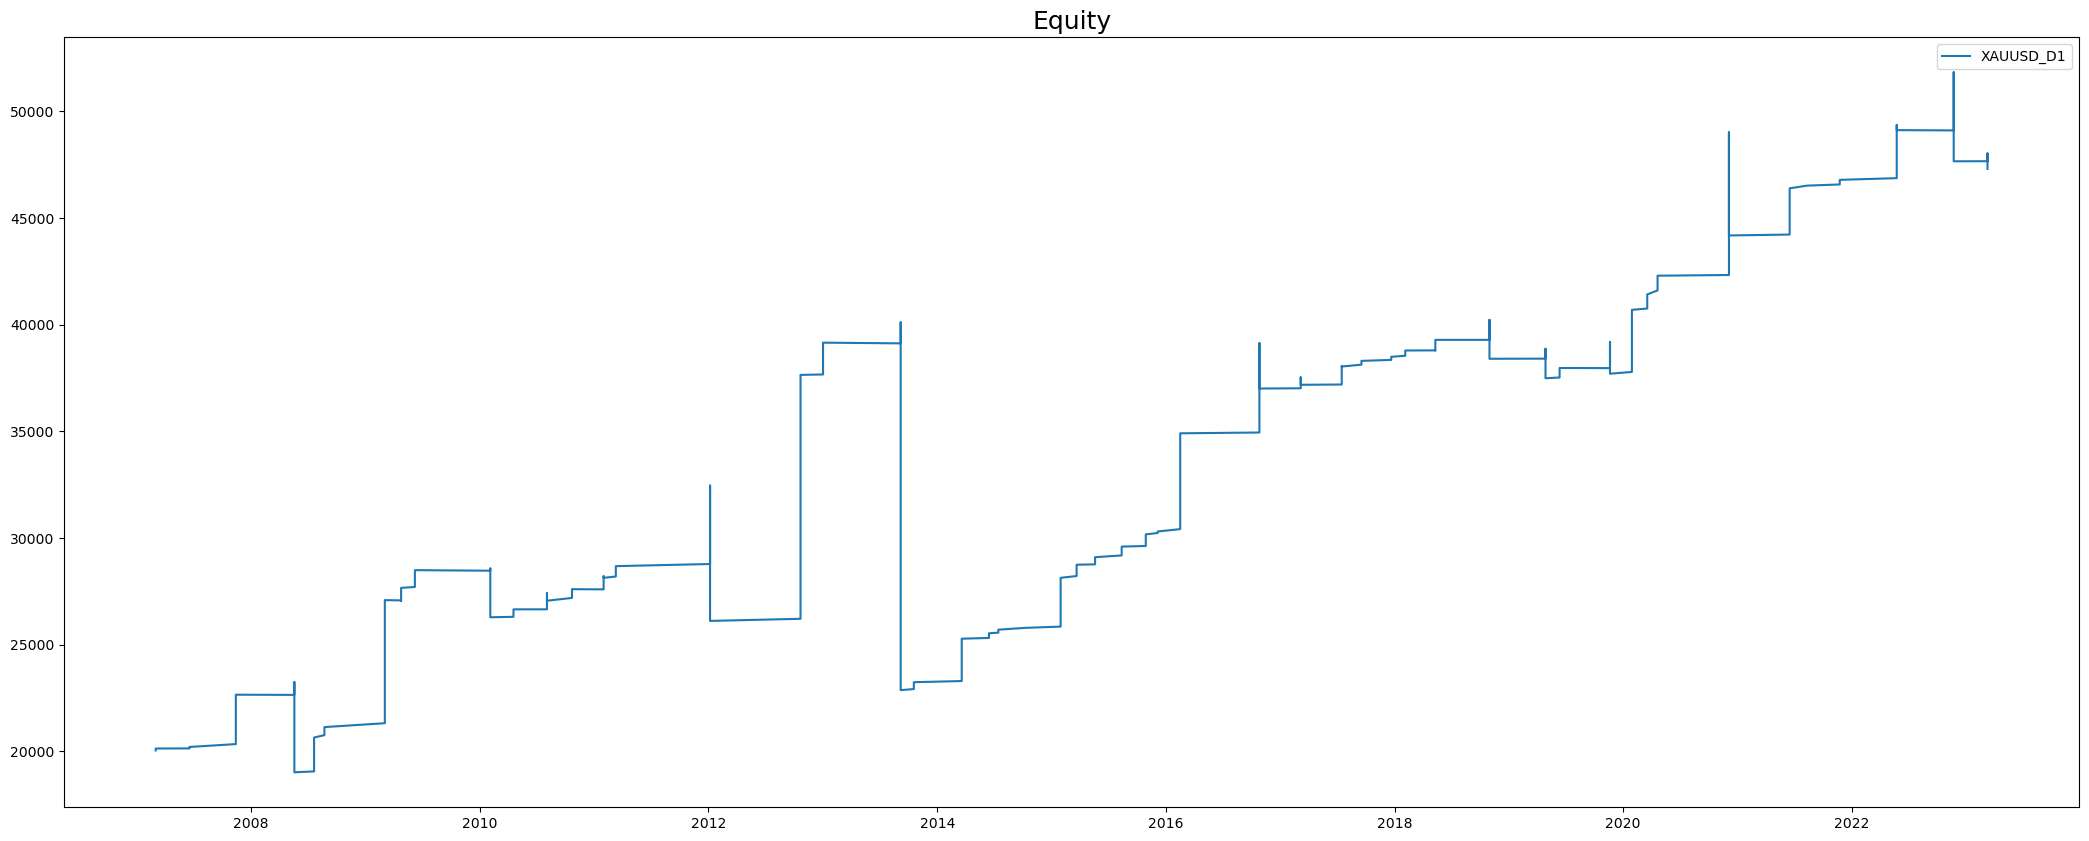

In [10]:
plot_equity_trades(result_D1['_trades'],'XAUUSD_D1' , account_size)

### Save output

In [11]:
# save_to_csv(result_D1, '../../out/Technical_Strategy/Fibonacci/Backtest/result_D1.csv')  

## TF H4

In [12]:
Backtest_H4 = Backtest(data_H4, strategy,
                       cash=account_size, margin=1/2000, )
result_H4 = Backtest_H4.run()
result_H4

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                   99.957653
Equity Final [$]                    26840.072
Equity Peak [$]                     51006.339
Return [%]                           34.20036
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                      1.4808
Volatility (Ann.) [%]               30.846592
Sharpe Ratio                         0.048005
Sortino Ratio                        0.075363
Calmar Ratio                         0.019809
Max. Drawdown [%]                  -74.755232
Avg. Drawdown [%]                   -3.239153
Max. Drawdown Duration     4027 days 12:00:00
Avg. Drawdown Duration       64 days 03:00:00
# Trades                                 6502
Win Rate [%]                        63.641956
Best Trade [%]                      20.934391
Worst Trade [%]                    -15.225838
Avg. Trade [%]                    

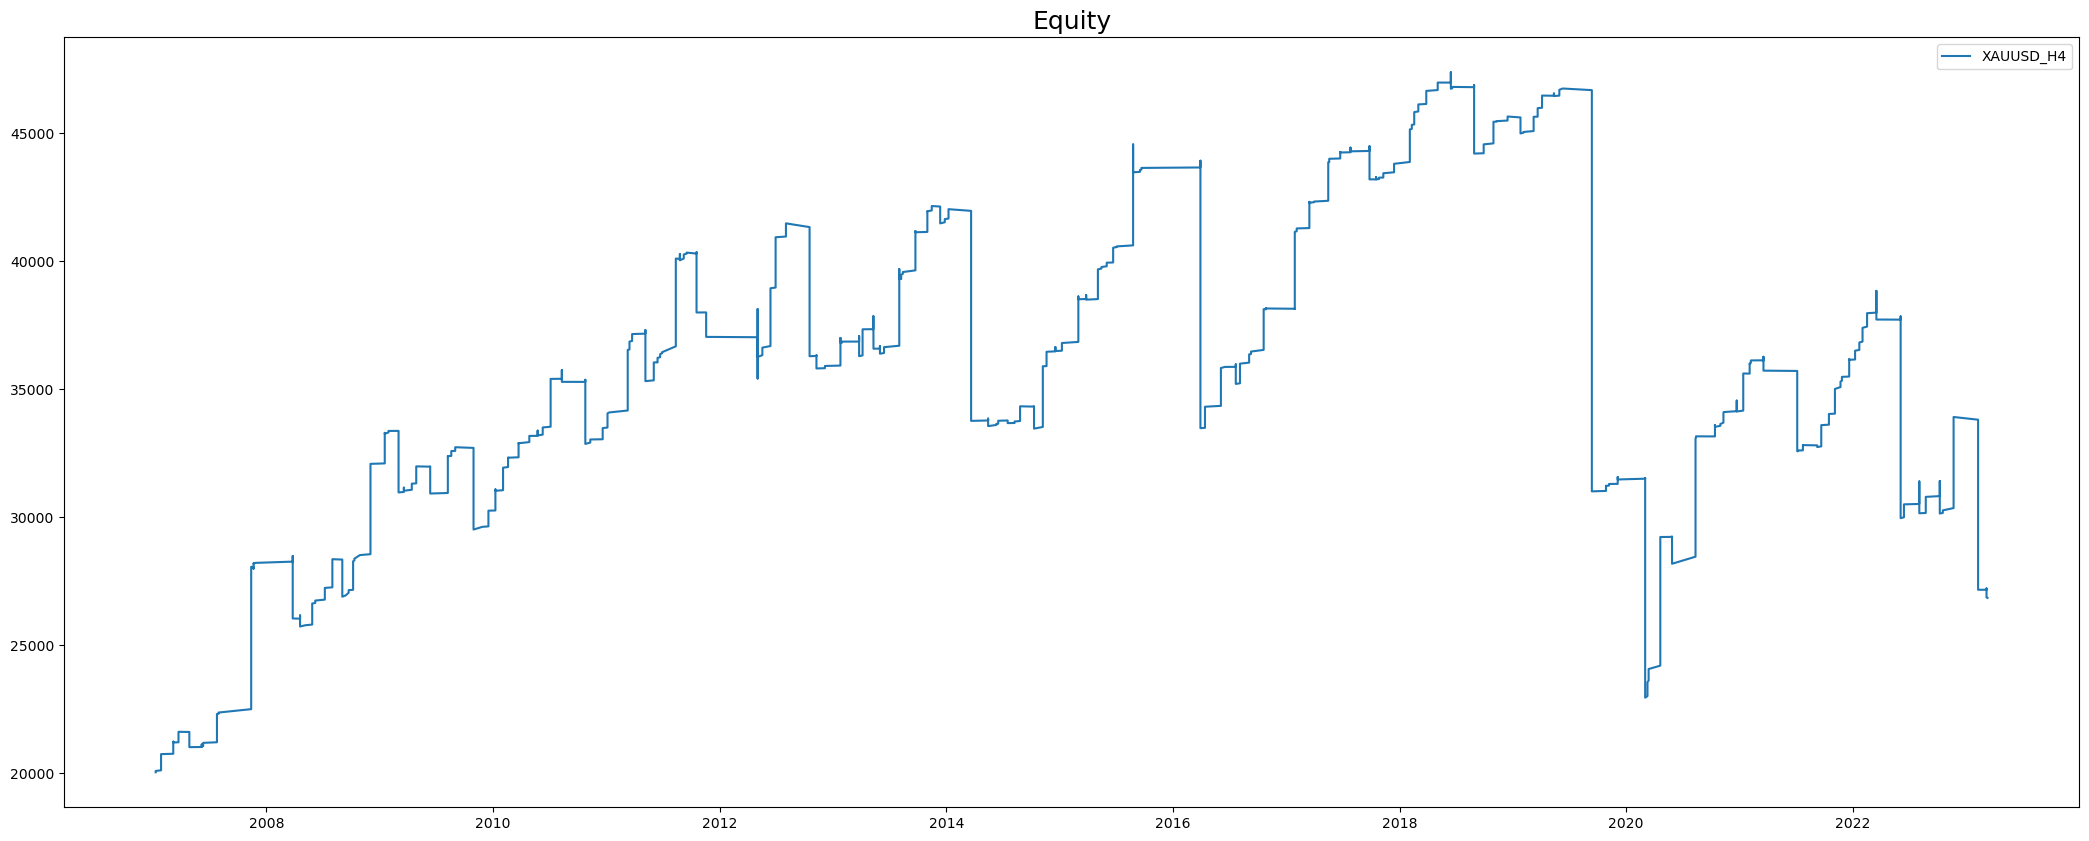

In [13]:
plot_equity_trades(result_H4['_trades'], 'XAUUSD_H4' , account_size)

### Save output

In [14]:
# save_to_csv(result_H4, '../../out/Technical_Strategy/Fibonacci/Backtest/result_H4.csv')  

## TF H1

In [15]:
Backtest_H1 = Backtest(data_H1, strategy,
                       cash=account_size, margin=1/2000, )
result_H1 = Backtest_H1.run()
result_H1

NameError: name 'data_H1' is not defined

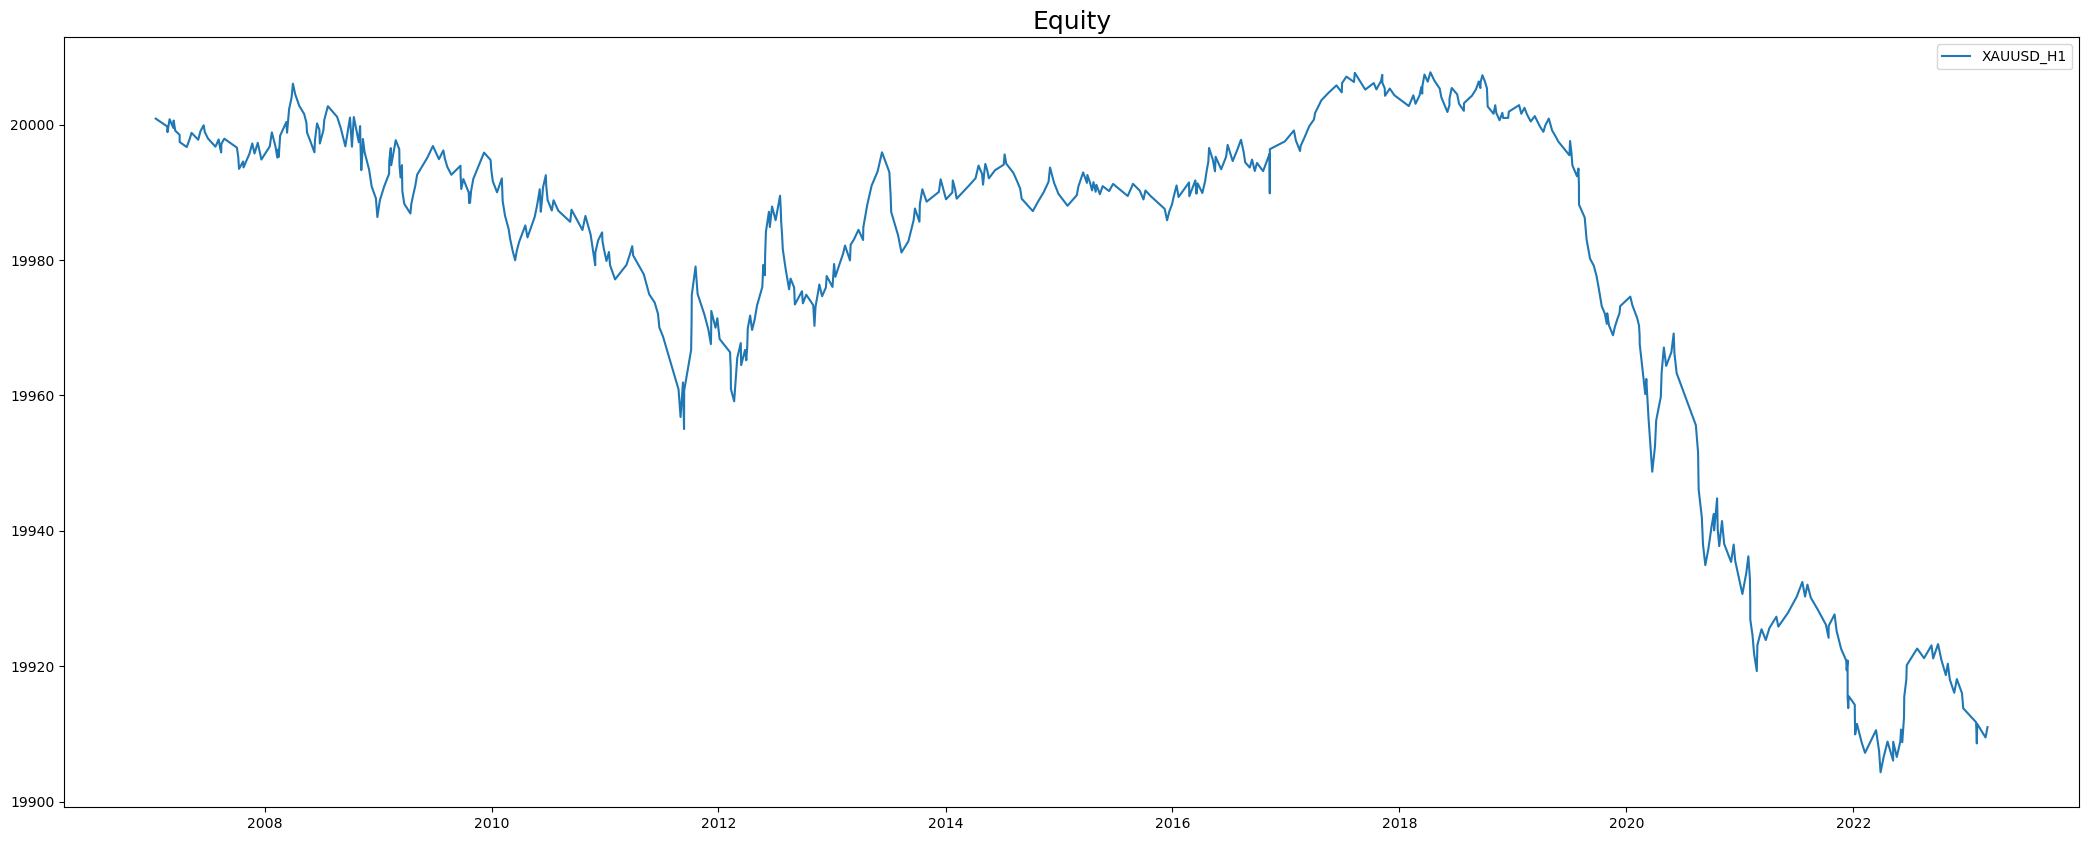

In [ ]:
plot_equity_trades(result_H1['_trades'], 'XAUUSD_H1', account_size)

### Save output

In [ ]:
save_to_csv(result_H1, '../../out/Technical_Strategy/Fibonacci/Backtest/result_H1.csv')  

## TF M30 

In [ ]:
Backtest_M30 = Backtest(data_M30, strategy,
                       cash=account_size, margin=1/2000, )
result_M30 = Backtest_M30.run()
result_M30

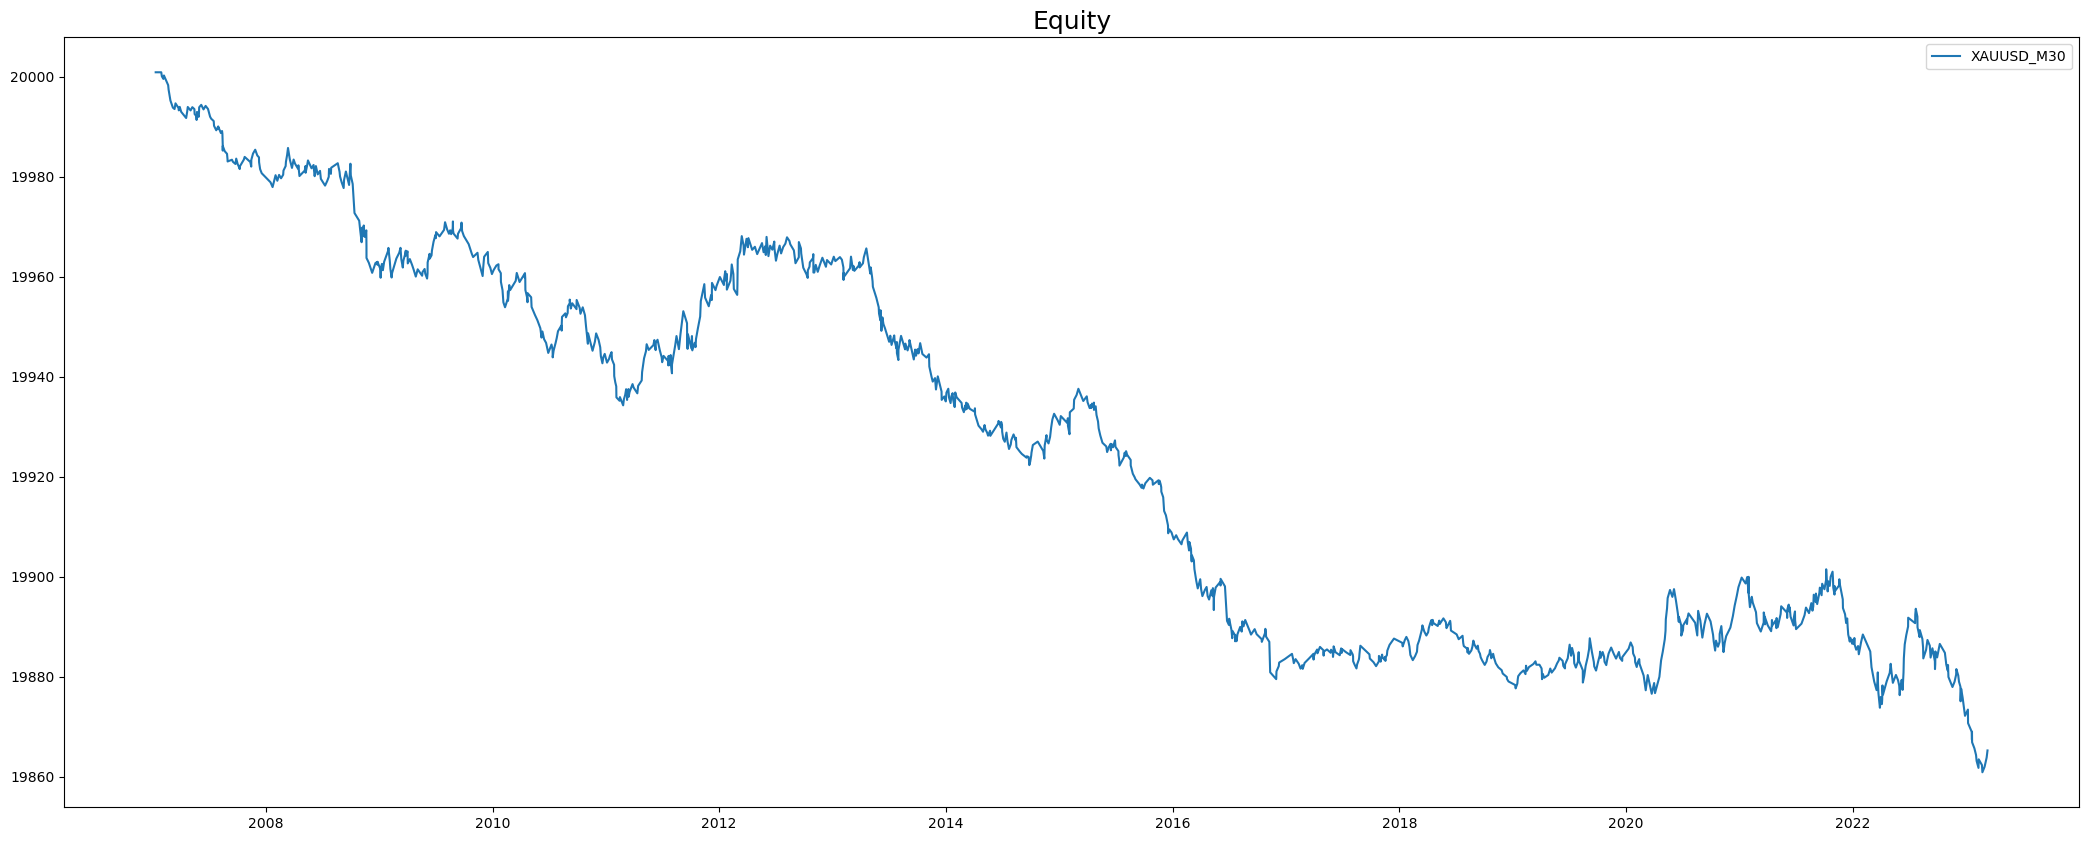

In [ ]:
plot_equity_trades(result_M30['_trades'], 'XAUUSD_M30', account_size)